In [80]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from collections import Counter
from scipy.stats import norm, beta, bernoulli
import pylab

In [2]:
import sys
sys.path.append("C:/Users/clementine.rosier/OneDrive - Ekimetrics/Documents/GitHub/dynamic_pricing")

%load_ext autoreload
%autoreload 2

In [3]:
#simple simulations
from src.simulations import SimpleSimulation
from src.simulation_melange_gaussien import GMixSimulation
from src.simulation_uniforme import UniformSimulation
#simulations with context
from src.context_generator import ContextGenerator
from src.simulation_with_context import ContextualDemandSimulation
#bandit algo
from src.binomial_bandit import BinomialBandit
from src.simple_bandit_epsilon_t_greedy import EpsilonTGreedyBandit
from src.simple_bandit_pure_greedy import PureGreedyBandit
from src.simple_bandit_epsilon_greedy import EpsilonGreedyBandit
from src.simple_bandit_ucb import UCBBandit
from src.context_bandit import ContextBandit
#evaluation algo (regret)
from src.evaluate_model import EvaluateBandit
from src.evaluate_with_context import EvaluateBanditContext

In [4]:
def plot_demand(simulation, min_price = 0, max_price = 150, n_points = 50, n_estimates_per_point = 40) : 
    prices = []
    revenues = []
    for price in np.linspace(min_price, max_price, n_points) : 
        revenues.extend( [int(simulation.evaluate(price)) * price for x in range(n_estimates_per_point)] )
        prices.extend([price for x in range(n_estimates_per_point)])
    
    a = np.array([prices, revenues])

    fig = plt.figure(figsize = (15,6), facecolor="w")
    ax = sns.lineplot(a[0], a[1])
    ax.legend("")

In [5]:
def test_bandit_thompson(simulation,k_p, alpha_0, beta_0,init_round=10,test_round=5000):
    hist = []
    regret = []
    reward_T = []
    parameters=np.array([np.array([alpha_0]),np.array([beta_0])])
    bandit = BinomialBandit(k_p, alpha_0, beta_0)
    evaluation=EvaluateBandit(bandit,simulation)
    print(evaluation.best_price)
    # Exploration round
    for i in range(init_round):
        for j in range(bandit.k):
            bandit.chose_action(force_action=j)
            price = k_p[bandit.action]
            reward = int(simulation.evaluate(price)) * price
            bandit.update(bandit.action, reward)
            regret.append(evaluation.get_regret(bandit.n_obs))
            parameters = np.append(parameters,np.array([np.array([bandit.alpha_n]),np.array([bandit.beta_n])]),axis=1)

    for i in range(test_round):
        bandit.chose_action(method="thompson")
        price = k_p[bandit.action]
        reward = int(simulation.evaluate(price)) * price
        bandit.update(bandit.action, reward)
        regret.append(evaluation.get_regret(bandit.n_obs))
        hist.append(k_p[bandit.action])
        parameters = np.append(parameters,np.array([np.array([bandit.alpha_n]),np.array([bandit.beta_n])]),axis=1)
    return hist,regret,parameters

In [22]:
def test_bandit_epsilon_t_greedy(simulation,k_p,c,d,init_round=10,test_round=5000):
    hist = []
    regret = []
    reward_T = []
    bandit = EpsilonTGreedyBandit(k_p, d,c)
    evaluation=EvaluateBandit(bandit,simulation)
    # Exploration round
    for i in range(init_round):
        for j in range(bandit.k):
            bandit.chose_action(force_action=j)
            price = k_p[bandit.action]
            reward = int(simulation.evaluate(price)) * price
            regret.append(evaluation.get_regret(bandit.n_obs))
            bandit.update(bandit.action, reward)

    for i in range(test_round):
        bandit.chose_action(method="greedy")
        price = k_p[bandit.action]
        reward = int(simulation.evaluate(price)) * price
        regret.append(evaluation.get_regret(bandit.n_obs))
        bandit.update(bandit.action, reward)
        hist.append(k_p[bandit.action])
        
    return hist,regret

In [23]:
def test_bandit_epsilon_greedy(simulation,k_p,epsilon,init_round=10,test_round=5000):
    hist = []
    regret = []
    reward_T = []
    bandit = EpsilonGreedyBandit(k_p, epsilon)
    evaluation=EvaluateBandit(bandit,simulation)
    # Exploration round
    for i in range(init_round):
        for j in range(bandit.k):
            bandit.chose_action(force_action=j)
            price = k_p[bandit.action]
            reward = int(simulation.evaluate(price)) * price
            regret.append(evaluation.get_regret(bandit.n_obs))
            bandit.update(bandit.action, reward)

    for i in range(test_round):
        bandit.chose_action(method="greedy")
        price = k_p[bandit.action]
        reward = int(simulation.evaluate(price)) * price
        regret.append(evaluation.get_regret(bandit.n_obs))
        bandit.update(bandit.action, reward)
        hist.append(k_p[bandit.action])
        
    return hist,regret

In [30]:
def test_bandit_pure_greedy(simulation,k_p,init_round=10,test_round=5000):
    hist = []
    regret = []
    reward_T = []
    bandit = PureGreedyBandit(k_p)
    evaluation=EvaluateBandit(bandit,simulation)
    # Exploration round
    for i in range(init_round):
        for j in range(bandit.k):
            bandit.chose_action(force_action=j)
            price = k_p[bandit.action]
            reward = int(simulation.evaluate(price)) * price
            regret.append(evaluation.get_regret(bandit.n_obs))
            bandit.update(bandit.action, reward)

    for i in range(test_round):
        bandit.chose_action(method="greedy")
        price = k_p[bandit.action]
        reward = int(simulation.evaluate(price)) * price
        regret.append(evaluation.get_regret(bandit.n_obs))
        bandit.update(bandit.action, reward)
        hist.append(k_p[bandit.action])
        
    return hist,regret

# Simulations

In [9]:
sim_u = UniformSimulation(35,75)
sim_u.optimal_price

37.499969482421875

In [10]:
sim_nl= SimpleSimulation(40,20)
sim_nl.optimal_price

33.3662109375

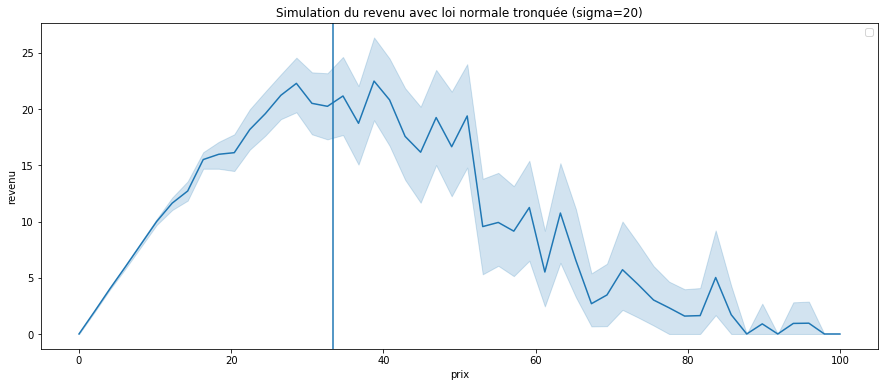

In [11]:
plot_demand(sim_nl,max_price = 100,n_estimates_per_point = 100)
plt.axvline(x=sim_nl.optimal_price)
plt.title('Simulation du revenu avec loi normale tronquée (sigma=20)')
plt.xlabel('prix')
plt.ylabel('revenu')
plt.savefig('dej_ML\demand_normale_gde.png')

In [12]:
sim_ns= SimpleSimulation(40,6)
sim_ns.optimal_price

32.13543701171875

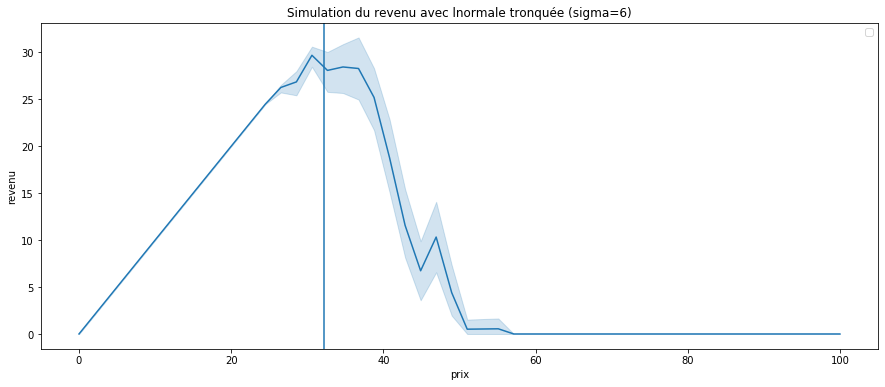

In [13]:
plot_demand(sim_ns,max_price = 100,n_estimates_per_point = 100)
plt.axvline(x=sim_ns.optimal_price)
plt.title('Simulation du revenu avec lnormale tronquée (sigma=6)')
plt.xlabel('prix')
plt.ylabel('revenu')
plt.savefig('dej_ML\demand_normale_pt.png')

In [14]:
sim_mix= GMixSimulation(30,2,70,10,0.5)
sim_mix.optimal_price

56.534423828125

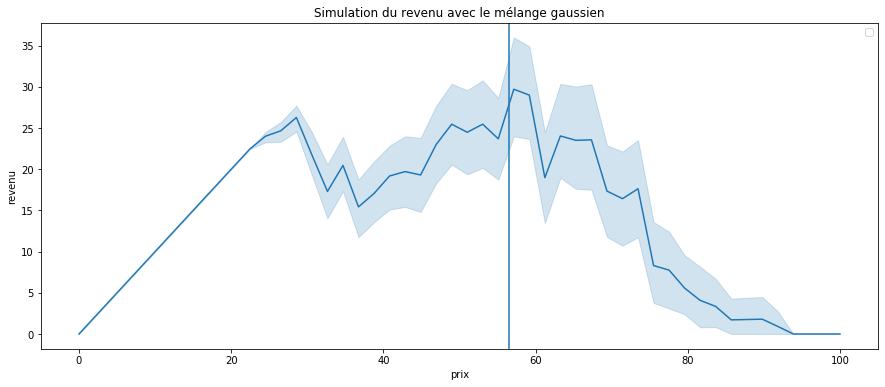

In [17]:
plot_demand(sim_mix,max_price = 100,n_estimates_per_point = 100)
plt.axvline(x=sim_mix.optimal_price)
plt.title('Simulation du revenu avec le mélange gaussien')
plt.xlabel('prix')
plt.ylabel('revenu')
plt.savefig('dej_ML\demand_mix.png')


# Comparaisons des algorithmes

### Avec la loi uniforme

In [18]:
size = 7
k_p = np.linspace(5,120,size)

In [57]:
c = 5
d = 3
e_t_greedy_uniform_1=test_bandit_epsilon_t_greedy(sim_u,k_p, c, d,init_round=0,test_round=10000)
e_t_greedy_uniform_2=test_bandit_epsilon_t_greedy(sim_u,k_p, c, d,init_round=10,test_round=10000)

BinomialBandit model for espilon_t-greedy instanciated with 7 arms.
BinomialBandit model for espilon_t-greedy instanciated with 7 arms.


In [58]:
epsilon = 0.1
e_1_greedy_uniform_1=test_bandit_epsilon_greedy(sim_u,k_p, epsilon,init_round=0,test_round=10000)
#e_1_greedy_uniform_2=test_bandit_epsilon_greedy(sim_u,k_p, epsilon,init_round=10,test_round=10000)

BinomialBandit model for espilon-greedy instanciated with 7 arms.


In [59]:
epsilon = 0.01
e_01_greedy_uniform_1=test_bandit_epsilon_greedy(sim_u,k_p, epsilon,init_round=0,test_round=10000)
#e_01_greedy_uniform_2=test_bandit_epsilon_greedy(sim_u,k_p, epsilon,init_round=10,test_round=10000)

BinomialBandit model for espilon-greedy instanciated with 7 arms.


In [60]:
pure_greedy_uniform_1=test_bandit_pure_greedy(sim_u,k_p,init_round=0,test_round=10000)
pure_greedy_uniform_2=test_bandit_pure_greedy(sim_u,k_p,init_round=1,test_round=10000)

BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.


In [61]:
alpha_0 = np.repeat(1,size)
beta_0 = np.repeat(1,size)
thompson_uniform_1=test_bandit_thompson(sim_u,k_p, alpha_0, beta_0,init_round=0,test_round=10000)
thompson_uniform_2=test_bandit_thompson(sim_u,k_p, alpha_0, beta_0,init_round=10,test_round=10000)

BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336


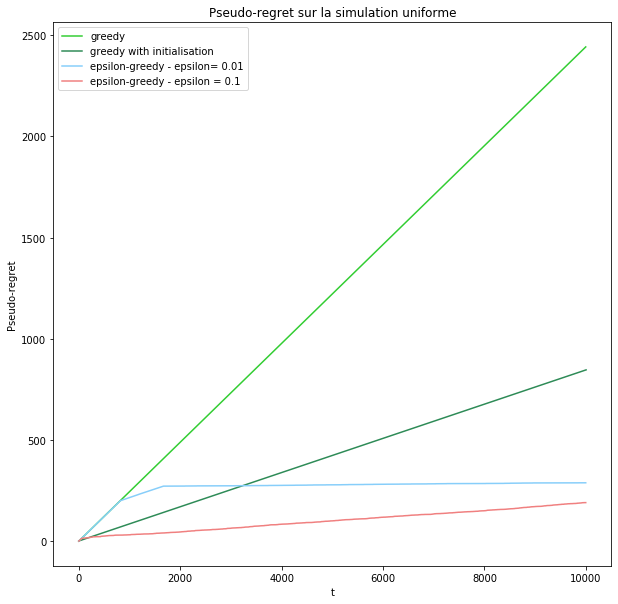

In [62]:
plt.rcParams["figure.figsize"] = (10,10)

#plt.plot(e_1_greedy_uniform_1[1],c='lightcoral')

#plt.plot(e_3_greedy_uniform_1[1],c='lightskyblue')
plt.plot(pure_greedy_uniform_1[1],c='limegreen')
plt.plot(pure_greedy_uniform_2[1],c='seagreen')
plt.plot(e_01_greedy_uniform_1[1],c='lightskyblue')
plt.plot(e_1_greedy_uniform_1[1],c='lightcoral')

#plt.plot(pure_greedy_uniform_1[1],c='limegreen')
plt.title('Pseudo-regret sur la simulation uniforme')
plt.ylabel('Pseudo-regret')
plt.xlabel('t')
#plt.axvline(x=7,c='black',linestyle='dashed')
plt.legend(("greedy","greedy with initialisation","epsilon-greedy - epsilon= 0.01","epsilon-greedy - epsilon = 0.1"))
plt.savefig('dej_ML\comparaison_uniform_greedy.png')

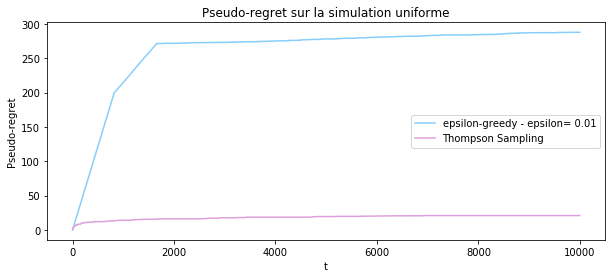

In [109]:
plt.rcParams["figure.figsize"] = (10,4)

#plt.plot(e_1_greedy_uniform_1[1],c='lightcoral')

#plt.plot(e_3_greedy_uniform_1[1],c='lightskyblue')

plt.plot(e_01_greedy_uniform_1[1],c='lightskyblue')
plt.plot(thompson_uniform_1[1],c='plum')


#plt.plot(pure_greedy_uniform_1[1],c='limegreen')
plt.title('Pseudo-regret sur la simulation uniforme')
plt.ylabel('Pseudo-regret')
plt.xlabel('t')
#plt.axvline(x=7,c='black',linestyle='dashed')
plt.legend(("epsilon-greedy - epsilon= 0.01","Thompson Sampling"))
plt.savefig('dej_ML\comparaison_uniform_TH_greedy.png')

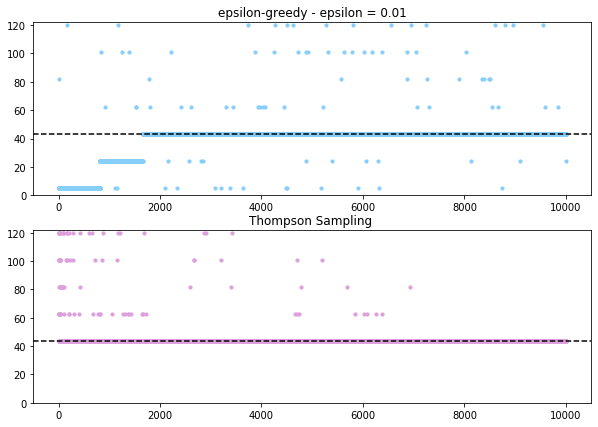

In [112]:
plt.rcParams["figure.figsize"] = (10,7)
time=range(10000)
plt.title('Prix joués lors des 3000 derniers tirages')


plt.subplot(2,1,1)
plt.scatter(time,e_01_greedy_uniform_1[0][0:10000],c='lightskyblue',s=10)
plt.axhline(y=43.3333333333333368,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('epsilon-greedy - epsilon = 0.01')

plt.subplot(2,1,2)
plt.scatter(time,thompson_uniform_1[0][0:10000],c='plum',s=10)
plt.axhline(y=43.333333333333336,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('Thompson Sampling ')



plt.savefig('dej_ML\prix_comparaison_uniform_Th_greedy.png')

### robustesse des méthodes

In [73]:
nb_test=1000
nb_round=1000

In [74]:
regret_greedy=[]
price_greedy=[]
regret_greedy_v=[]
price_greedy_v=[]
for i in range(nb_test):
    bandit_greedy=test_bandit_pure_greedy(sim_u,k_p,0,nb_round)
    price_greedy.append(bandit_greedy[0][nb_round-1])
    regret_greedy.append(bandit_greedy[1][nb_round-1])
    price_greedy_v.append(bandit_greedy[0][500])
    regret_greedy_v.append(bandit_greedy[1][500])

BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.


C:/Users/clementine.rosier/OneDrive - Ekimetrics/Documents/GitHub/dynamic_pricing\src\simple_bandit_pure_greedy.py:55: RuntimeWarning: invalid value encountered in true_divide
  average_reward = self.k_p*np.nan_to_num(self.n_pos/(self.n_obs))


BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 

BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 

BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 

BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 

BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 

BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 

BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 

BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 

In [76]:
regret_epsilon=[]
price_epsilon=[]
regret_epsilon_v=[]
price_epsilon_v=[]
epsilon_01 = 0.01
for i in range(nb_test):
    bandit_epsilon=test_bandit_epsilon_greedy(sim_u,k_p,epsilon_01,0,nb_round)
    price_epsilon.append(bandit_epsilon[0][nb_round-1])
    regret_epsilon.append(bandit_epsilon[1][nb_round-1])
    price_epsilon_v.append(bandit_epsilon[0][500])
    regret_epsilon_v.append(bandit_epsilon[1][500])

BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.


C:/Users/clementine.rosier/OneDrive - Ekimetrics/Documents/GitHub/dynamic_pricing\src\simple_bandit_epsilon_greedy.py:62: RuntimeWarning: invalid value encountered in true_divide
  average_reward = self.k_p*np.nan_to_num(self.n_pos/(self.n_obs))


BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBa

BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBa

BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBa

BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBa

BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBa

BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBa

BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBa

BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBa

In [78]:
alpha_0 = np.repeat(1,size)
beta_0 = np.repeat(1,size)

regret_th=[]
price_th=[]
regret_th_v=[]
price_th_v=[]
for i in range(nb_test):
    bandit_th=test_bandit_thompson(sim_u,k_p,alpha_0,beta_0,0,nb_round)
    price_th.append(bandit_th[0][nb_round-1])
    regret_th.append(bandit_th[1][nb_round-1])
    price_th_v.append(bandit_th[0][500])
    regret_th_v.append(bandit_th[1][500])

BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBa

BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBa

BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBa

BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBa

BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBa

BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBa

BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBa

BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBa

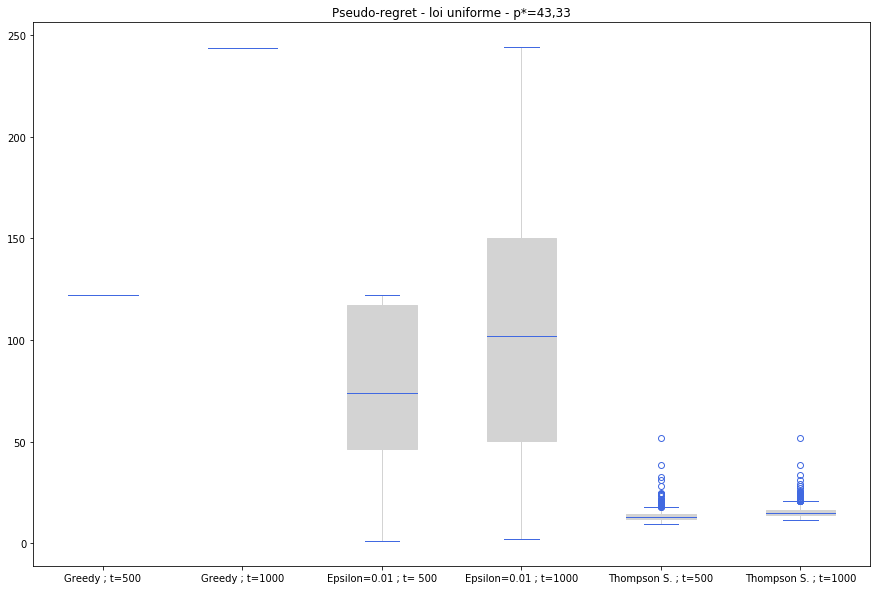

In [101]:
c1="royalblue"
c="lightgrey"
BoxName = ['Greedy ; t=500','Greedy ; t=1000','Epsilon=0.01 ; t= 500','Epsilon=0.01 ; t=1000','Thompson S. ; t=500','Thompson S. ; t=1000']

plt.rcParams["figure.figsize"] = (15,10)
data = [regret_greedy_v,regret_greedy,regret_epsilon_v,regret_epsilon,regret_th_v,regret_th]

plt.boxplot(data,patch_artist=True,boxprops=dict( facecolor=c,color=c),
            capprops=dict(color=c1),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c1),
            medianprops=dict(color=c1))

#plt.ylim(0,30)

pylab.xticks([1,2,3,4,5,6], BoxName)

plt.title('Pseudo-regret - loi uniforme - p*=43,33')

plt.savefig('dej_ML\Boxplot_robustesse_uniforme.png')
plt.show()

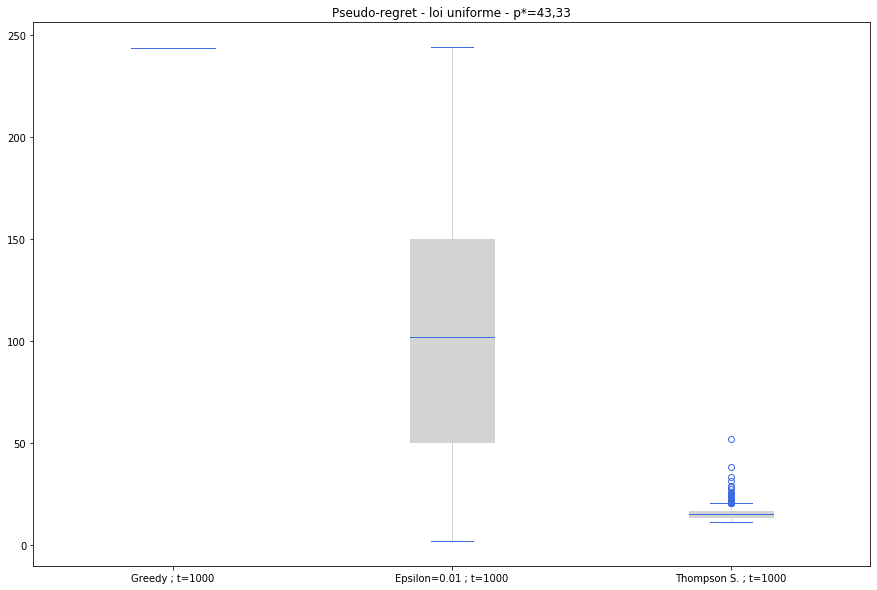

In [116]:
c1="royalblue"
c="lightgrey"
BoxName = ['Greedy ; t=1000','Epsilon=0.01 ; t=1000','Thompson S. ; t=1000']

plt.rcParams["figure.figsize"] = (15,10)
data = [regret_greedy,regret_epsilon,regret_th]

plt.boxplot(data,patch_artist=True,boxprops=dict( facecolor=c,color=c),
            capprops=dict(color=c1),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c1),
            medianprops=dict(color=c1))

#plt.ylim(0,30)

pylab.xticks([1,2,3], BoxName)

plt.title('Pseudo-regret - loi uniforme - p*=43,33')

plt.savefig('dej_ML\Boxplot_robustesse_uniforme_zoom.png')
plt.show()

### avec le mix gaussien

In [64]:
epsilon_1 = 0.1
e_1_greedy_mix_1=test_bandit_epsilon_greedy(sim_mix,k_p, epsilon_1,init_round=0,test_round=10000)
#e_1_greedy_uniform_2=test_bandit_epsilon_greedy(sim_mix,k_p, epsilon_1,init_round=10,test_round=10000)

epsilon_01 = 0.01
e_01_greedy_mix_1=test_bandit_epsilon_greedy(sim_mix,k_p, epsilon_01,init_round=0,test_round=10000)
#e_01_greedy_uniform_2=test_bandit_epsilon_greedy(sim_mix,k_p, epsilon_01,init_round=10,test_round=10000)

pure_greedy_mix_1=test_bandit_pure_greedy(sim_mix,k_p,init_round=0,test_round=10000)
pure_greedy_mix_2=test_bandit_pure_greedy(sim_mix,k_p,init_round=1,test_round=10000)

alpha_0 = np.repeat(1,size)
beta_0 = np.repeat(1,size)
thompson_mix_1=test_bandit_thompson(sim_mix,k_p, alpha_0, beta_0,init_round=0,test_round=10000)
thompson_mix_2=test_bandit_thompson(sim_mix,k_p, alpha_0, beta_0,init_round=10,test_round=10000)


BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5


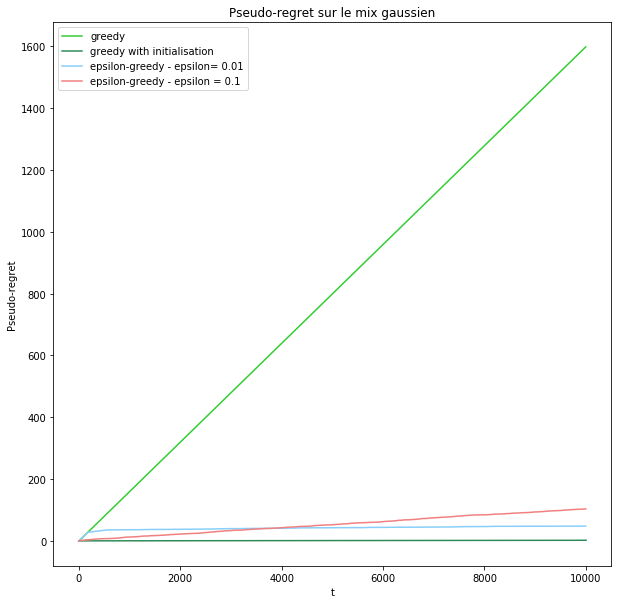

In [65]:
plt.rcParams["figure.figsize"] = (10,10)

#plt.plot(e_1_greedy_uniform_1[1],c='lightcoral')

#plt.plot(e_3_greedy_uniform_1[1],c='lightskyblue')
plt.plot(pure_greedy_mix_1[1],c='limegreen')
plt.plot(pure_greedy_mix_2[1],c='seagreen')
plt.plot(e_01_greedy_mix_1[1],c='lightskyblue')
plt.plot(e_1_greedy_mix_1[1],c='lightcoral')

#plt.plot(pure_greedy_uniform_1[1],c='limegreen')
plt.title('Pseudo-regret sur le mix gaussien')
plt.ylabel('Pseudo-regret')
plt.xlabel('t')
#plt.axvline(x=7,c='black',linestyle='dashed')
plt.legend(("greedy","greedy with initialisation","epsilon-greedy - epsilon= 0.01","epsilon-greedy - epsilon = 0.1"))
plt.savefig('dej_ML\comparaison_mix_gaussien_greedy.png')

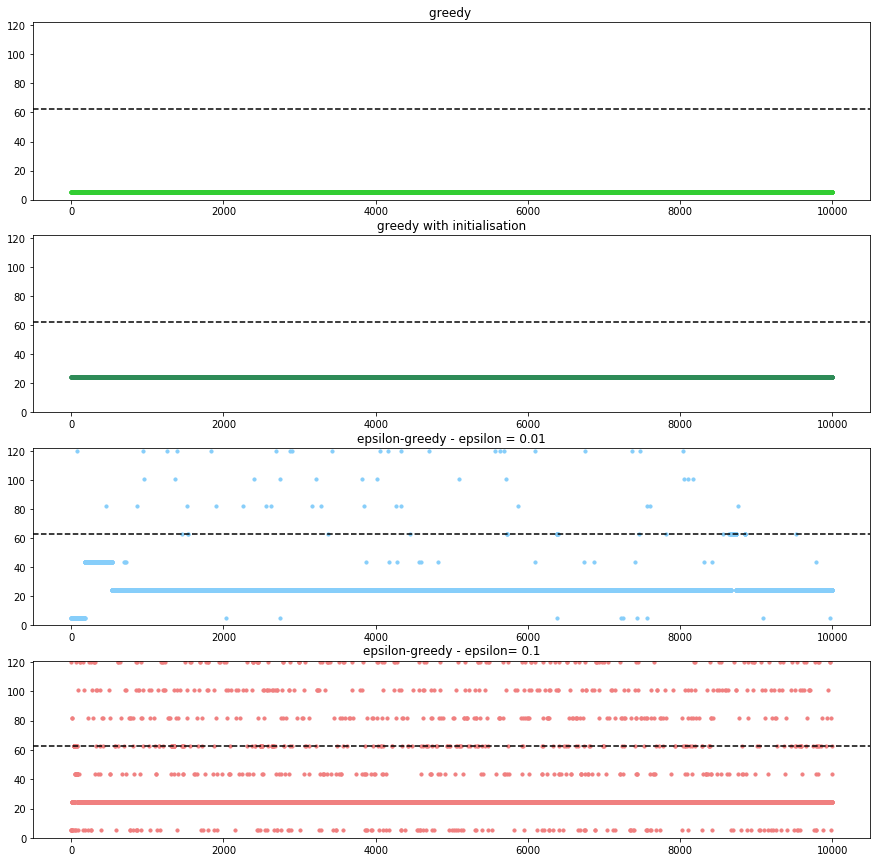

In [68]:
opt_price=62.5
plt.rcParams["figure.figsize"] = (15,15)
time=range(10000)
plt.title('Prix joués lors des 3000 derniers tirages')
plt.subplot(4,1,4)
plt.scatter(time,e_1_greedy_mix_1[0][0:10000],c='lightcoral',s=10)
plt.axhline(y=opt_price,c='black',linestyle='dashed')
plt.ylim(0,121)
plt.title('epsilon-greedy - epsilon= 0.1')

plt.subplot(4,1,3)
plt.scatter(time,e_01_greedy_mix_1[0][0:10000],c='lightskyblue',s=10)
plt.axhline(y=opt_price,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('epsilon-greedy - epsilon = 0.01')

plt.subplot(4,1,1)
plt.scatter(time,pure_greedy_mix_1[0][0:10000],c='limegreen',s=10)
plt.axhline(y=opt_price,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('greedy ')

plt.subplot(4,1,2)
plt.scatter(time,pure_greedy_mix_2[0][0:10000],c='seagreen',s=10)
plt.axhline(y=opt_price,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('greedy with initialisation')

plt.savefig('dej_ML\prix_comparaison_mix_gaussien_v3.png')

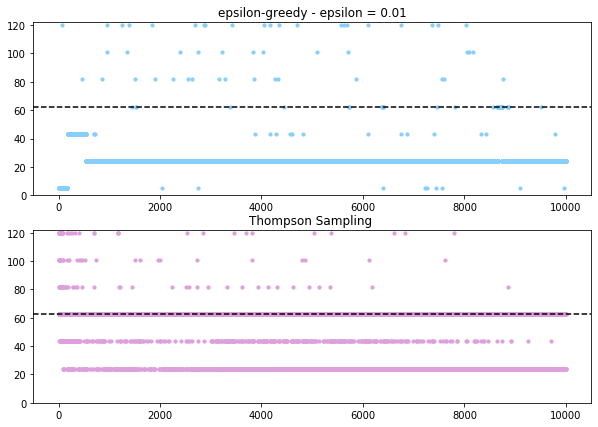

In [114]:
plt.rcParams["figure.figsize"] = (10,7)
time=range(10000)
plt.title('Prix joués lors des 3000 derniers tirages')


plt.subplot(2,1,1)
plt.scatter(time,e_01_greedy_mix_1[0][0:10000],c='lightskyblue',s=10)
plt.axhline(y=opt_price,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('epsilon-greedy - epsilon = 0.01')

plt.subplot(2,1,2)
plt.scatter(time,thompson_mix_1[0][0:10000],c='plum',s=10)
plt.axhline(y=opt_price,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('Thompson Sampling ')



plt.savefig('dej_ML\prix_comparaison_MG_Th_greedy.png')

In [102]:
### test robustesse

In [103]:
regret_greedy_m=[]
price_greedy_m=[]
regret_greedy_v_m=[]
price_greedy_v_m=[]
for i in range(nb_test):
    bandit_greedy=test_bandit_pure_greedy(sim_mix,k_p,0,nb_round)
    price_greedy_m.append(bandit_greedy[0][nb_round-1])
    regret_greedy_m.append(bandit_greedy[1][nb_round-1])
    price_greedy_v_m.append(bandit_greedy[0][500])
    regret_greedy_v_m.append(bandit_greedy[1][500])

BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.


C:/Users/clementine.rosier/OneDrive - Ekimetrics/Documents/GitHub/dynamic_pricing\src\simple_bandit_pure_greedy.py:55: RuntimeWarning: invalid value encountered in true_divide
  average_reward = self.k_p*np.nan_to_num(self.n_pos/(self.n_obs))


BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 

BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 

BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 

BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 

BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 

BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 

BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 

BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 7 arms.
BinomialBandit model for pure greedy instanciated with 

In [104]:
regret_epsilon_m=[]
price_epsilon_m=[]
regret_epsilon_v_m=[]
price_epsilon_v_m=[]
epsilon_01 = 0.01
for i in range(nb_test):
    bandit_epsilon=test_bandit_epsilon_greedy(sim_mix,k_p,epsilon_01,0,nb_round)
    price_epsilon_m.append(bandit_epsilon[0][nb_round-1])
    regret_epsilon_m.append(bandit_epsilon[1][nb_round-1])
    price_epsilon_v_m.append(bandit_epsilon[0][500])
    regret_epsilon_v_m.append(bandit_epsilon[1][500])

BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.


C:/Users/clementine.rosier/OneDrive - Ekimetrics/Documents/GitHub/dynamic_pricing\src\simple_bandit_epsilon_greedy.py:62: RuntimeWarning: invalid value encountered in true_divide
  average_reward = self.k_p*np.nan_to_num(self.n_pos/(self.n_obs))


BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBa

BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBa

BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBa

BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBa

BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBa

BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBa

BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBa

BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBa

In [105]:
alpha_0 = np.repeat(1,size)
beta_0 = np.repeat(1,size)

regret_th_m=[]
price_th_m=[]
regret_th_v_m=[]
price_th_v_m=[]
for i in range(nb_test):
    bandit_th=test_bandit_thompson(sim_mix,k_p,alpha_0,beta_0,0,nb_round)
    price_th_m.append(bandit_th[0][nb_round-1])
    regret_th_m.append(bandit_th[1][nb_round-1])
    price_th_v_m.append(bandit_th[0][500])
    regret_th_v_m.append(bandit_th[1][500])

BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBand

BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBand

BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBand

BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBand

BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBand

BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBand

BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBand

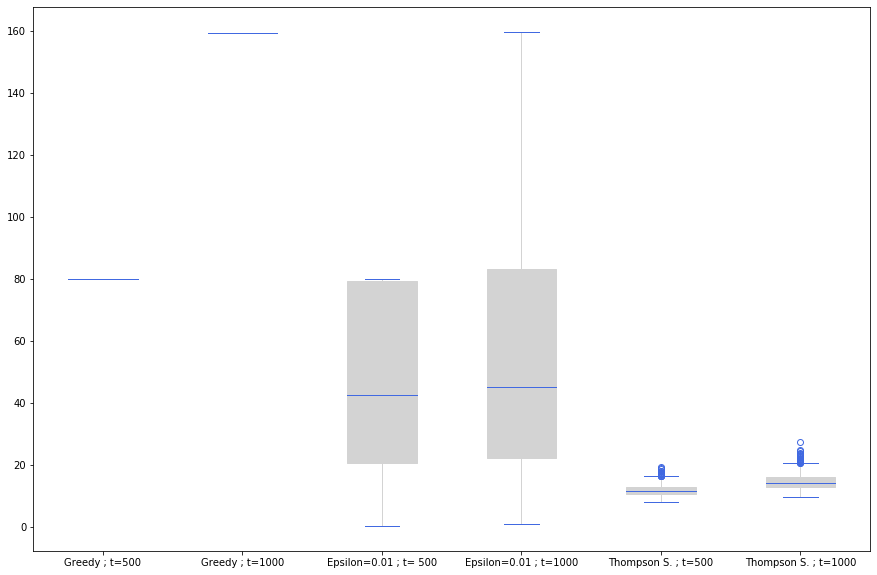

In [106]:
c1="royalblue"
c="lightgrey"
BoxName = ['Greedy ; t=500','Greedy ; t=1000','Epsilon=0.01 ; t= 500','Epsilon=0.01 ; t=1000','Thompson S. ; t=500','Thompson S. ; t=1000']

plt.rcParams["figure.figsize"] = (15,10)
data = [regret_greedy_v_m,regret_greedy_m,regret_epsilon_v_m,regret_epsilon_m,regret_th_v_m,regret_th_m]

plt.boxplot(data,patch_artist=True,boxprops=dict( facecolor=c,color=c),
            capprops=dict(color=c1),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c1),
            medianprops=dict(color=c1))

#plt.ylim(0,30)

pylab.xticks([1,2,3,4,5,6], BoxName)


plt.savefig('dej_ML\Boxplot_robustesse_mixG.png')
plt.show()